In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
df = pd.read_csv("strictly_balanced_movies.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14739 entries, 0 to 14738
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          14739 non-null  int64 
 1   title       14739 non-null  object
 2   overview    14739 non-null  object
 3   genres      14739 non-null  object
 4   poster_url  14739 non-null  object
dtypes: int64(1), object(4)
memory usage: 575.9+ KB


In [4]:
# to identify the different genres in our dataset 

import ast

def clean_genres(x):
    if isinstance(x, list):
        return [genre.strip() for genre in x if isinstance(genre, str)]
    
    if isinstance(x, str):
        return [genre.strip() for genre in x.split(',') if genre.strip()]
    
    return []

df["genres"] = df["genres"].apply(clean_genres)

all_genres = sorted(set(genre for genre_list in df["genres"] for genre in genre_list))
print(f"Number of unique genres: {len(all_genres)}")
print("List of genres:")
print(all_genres)

Number of unique genres: 14
List of genres:
['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Science Fiction', 'Thriller']


In [ ]:
from IPython.display import display

df['num_genres'] = df['genres'].apply(len)
average_genres = df['num_genres'].mean()
print(f"Average number of genres per movie: {average_genres}")

one_genre_movie = df[df['num_genres'] == 1]
multiple_genres = df[df['num_genres'] > 2]
max_genres = df.loc[df['num_genres'].idxmax()]

Average number of genres per movie: 1.6781328448334352


In [6]:
print("Movies with less than the average genres:")
display(one_genre_movie)

Movies with less than the average genres:


,id,title,overview,genres,poster_url,num_genres
2,12540,Bring It On Again,When new students can't get onto their college...,[Comedy],https://image.tmdb.org/t/p/w500/slevjvJcGRvFZ3...,1
3,15261,Bring It On: In It to Win It,Fourth 'Bring It On' movie is set at a cheerle...,[Comedy],https://image.tmdb.org/t/p/w500/hMRjQuTZQ8bZNr...,1
9,141028,Flesh for Sale,The porn industry has grown from a product pur...,[Documentary],https://image.tmdb.org/t/p/w500/oPrRaowFYtqBhB...,1
10,45887,Alive in Joburg,A documentary-style short film about the arriv...,[Science Fiction],https://image.tmdb.org/t/p/w500/nQFaObHn4rLQ0d...,1
12,81550,"Ice Cream, I Scream","Ali, who is ice cream salesman in Mugla, tries...",[Comedy],https://image.tmdb.org/t/p/w500/nM3rXq2EpfpcwQ...,1
...,...,...,...,...,...,...
14727,1064486,Memoir of a Snail,Forcibly separated from her twin brother when ...,[Animation],https://image.tmdb.org/t/p/w500/57AgZv1ITeBLSh...,1
14728,558449,Gladiator II,Years after witnessing the death of the revere...,[Adventure],https://image.tmdb.org/t/p/w500/2cxhvwyEwRlysA...,1
14729,539972,Kraven the Hunter,Kraven Kravinoff's complex relationship with h...,[Adventure],https://image.tmdb.org/t/p/w500/1GvBhRxY6MELDf...,1
14731,533535,Deadpool & Wolverine,A listless Wade Wilson toils away in civilian ...,[Science Fiction],https://image.tmdb.org/t/p/w500/8cdWjvZQUExUUT...,1


In [7]:
print("Movies with more than average number of genres:")
display(multiple_genres)

Movies with more than average number of genres:


,id,title,overview,genres,poster_url,num_genres
7,32532,Everything Will Be OK,A series of dark and troubling events forces B...,"[Animation, Drama, Comedy]",https://image.tmdb.org/t/p/w500/agwgqQLcNB77hk...,3
11,46921,The Cat with Hands,"The story of a cat who, legend has it, longs t...","[Fantasy, Mystery, Horror, Animation]",https://image.tmdb.org/t/p/w500/hEVY60G2rmeXm3...,4
14,45336,The Employment,A man prepares and goes to work in a bizarre w...,"[Animation, Drama, Comedy]",https://image.tmdb.org/t/p/w500/f6koGitPw8EsU0...,3
28,40432,The 4th Floor,Three friends in wheelchairs welcome a new pat...,"[Family, Drama, Comedy]",https://image.tmdb.org/t/p/w500/5vsQpIDyyMYmUX...,3
36,13646,"Moscow, Belgium",‘Moscou’ is a densely populated working class ...,"[Romance, Drama, Comedy]",https://image.tmdb.org/t/p/w500/sYw8pc8JwXIgNB...,3
...,...,...,...,...,...,...
14724,1184918,The Wild Robot,"After a shipwreck, an intelligent robot called...","[Animation, Family, Science Fiction]",https://image.tmdb.org/t/p/w500/wTnV3PCVW5O92J...,3
14726,823219,Flow,"A solitary cat, displaced by a great flood, fi...","[Fantasy, Animation, Adventure]",https://image.tmdb.org/t/p/w500/imKSymKBK7o73s...,3
14730,519182,Despicable Me 4,"Gru and Lucy and their girls—Margo, Edith and ...","[Animation, Family, Science Fiction]",https://image.tmdb.org/t/p/w500/wWba3TaojhK7Nd...,3
14735,1241982,Moana 2,After receiving an unexpected call from her wa...,"[Animation, Family, Adventure]",https://image.tmdb.org/t/p/w500/aLVkiINlIeCkcZ...,3


In [8]:
print("Movie with the highest number of genres:")
display(max_genres)

Movie with the highest number of genres:


id                                                       361472
title                 The Grim Adventures of the Kids Next Door
overview      A crossover with The Grim Adventures of Billy ...
genres        [Animation, Fantasy, Family, Science Fiction, ...
poster_url    https://image.tmdb.org/t/p/w500/gDodJ6LhGOWgx8...
num_genres                                                    7
Name: 3928, dtype: object

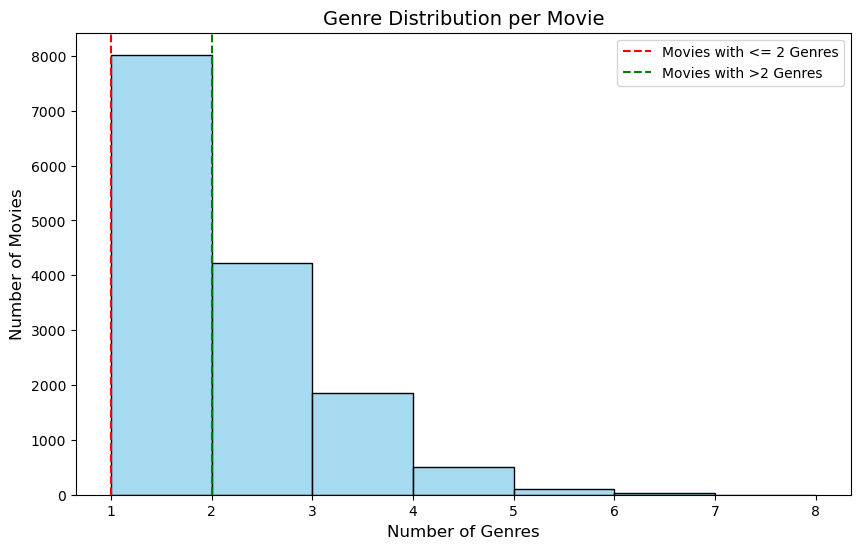

In [7]:
# visualize the movie genre distribution
plt.figure(figsize=(10,6))
sns.histplot(df['num_genres'], kde=False, bins=range(1, df['num_genres'].max() + 2), color='skyblue', edgecolor='black')
plt.axvline(x=1, color='red', linestyle='--', label="Movies with <= 2 Genres")
plt.axvline(x=2, color='green', linestyle='--', label="Movies with >2 Genres")
plt.title('Genre Distribution per Movie', fontsize=14)
plt.xlabel('Number of Genres', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.legend()
plt.show()

In [57]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


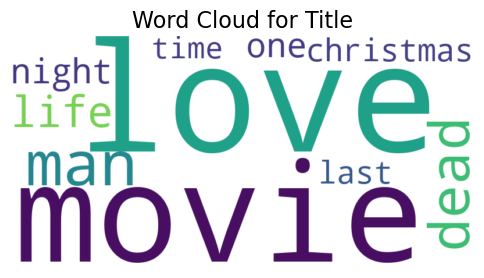

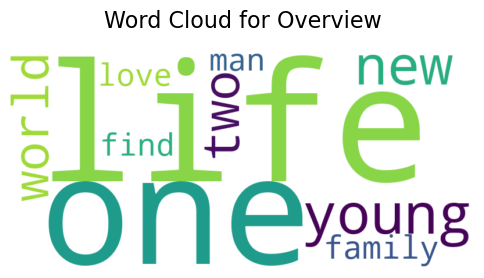

In [8]:
# Because this is a text-focused model, we review the common words across the title, synposis and genres
from wordcloud import WordCloud

stop_words1 = set(stopwords.words('english'))

def common_words(df, columns, top_n=10):
    common_words = {}
    for col in columns:
        text_data1 = df[col].dropna().tolist()
        if isinstance(text_data1[0], list):
            flat_text1 = [' '.join(item) for item in text_data1]
        else:
            flat_text1 = text_data1
            full_text1 = ' '.join(flat_text1).lower()
            full_text1 = re.sub(r"<.*?>", "", full_text1)  
            full_text1 = re.sub(r"[^a-zA-Z\s]", "", full_text1) 
 
            tokens1 = word_tokenize(full_text1)
            tokens1 = [w for w in tokens1 if w not in stop_words1 and len(w) > 2]

            word_counts1 = Counter(tokens1)
            common_words[col] = word_counts1.most_common(top_n)
    return common_words

def wordcloud(common_words_dict):
    for col, words in common_words_dict.items():
        word_freq1 = dict(words)
        wc1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq1)
        
        plt.figure(figsize=(6, 4))
        plt.imshow(wc1, interpolation='bilinear')
        plt.title(f"Word Cloud for {col.capitalize()}", fontsize=16)
        plt.axis('off')
        plt.show()

top_words = common_words(df, ["genres", "title", "overview"])
wordcloud(top_words)


In [ ]:
"""
# Observation from the Data Analysis
# 1 - The average number of genres per movie is 13
# 2 - There are over 8000 movies less than the average number of genre per movie
# 3 - There are over 600 movies more than the average number of genre per movie
# 4 - And the movie with highest genre had 7 genres
"""

In [ ]:
print(df['genres'].isna().sum())

print(df['genres'].dtype)

0
object


In [12]:
# using MultiLabelBinarizer to encode the genres
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df["genres"])


print(f"Genres encoded shape: {genres_encoded.shape}")
print("Sample of encoded genres:")
print(genres_encoded[:5])  


print(f"Unique genres found: {mlb.classes_}")

Genres encoded shape: (14739, 14)
Sample of encoded genres:
[[0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 0 0 0]]
Unique genres found: ['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'Horror' 'Mystery' 'Romance' 'Science Fiction'
 'Thriller']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
from collections import Counter
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        tokens = word_tokenize(text.lower())
        counter.update(tokens)
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab


class MovieGenreDataset(Dataset):
    def __init__(self, overviews, genres, vocab, max_len=300):
        self.overviews = overviews.reset_index(drop=True)
        self.genres = genres.reset_index(drop=True)
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.overviews)

    def __getitem__(self, idx):
        overview = self.overviews[idx]
        genre = torch.tensor(self.genres[idx], dtype=torch.float)

        tokens = word_tokenize(overview.lower())
        indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        indices = indices[:self.max_len] + [self.vocab['<PAD>']] * (self.max_len - len(indices))
        indices = torch.tensor(indices, dtype=torch.long)

        return indices, genre


class LSTMGenreClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1, dropout=0.5):
        super(LSTMGenreClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(out)
        return out


all_genres = sorted(set(g for genre_list in df['genres'] for g in genre_list))
mlb = MultiLabelBinarizer(classes=all_genres)
genre_encoded = mlb.fit_transform(df['genres'])

X_train, X_test, y_train, y_test = train_test_split(df['overview'], genre_encoded, test_size=0.2, random_state=42)

vocab = build_vocab(X_train)
max_len = 300

train_dataset = MovieGenreDataset(X_train, pd.Series(list(y_train)), vocab)
test_dataset = MovieGenreDataset(X_test, pd.Series(list(y_test)), vocab)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


model = LSTMGenreClassifier(
    vocab_size=len(vocab),
    embed_dim=128,
    hidden_dim=256,
    output_dim=len(all_genres),
    num_layers=1,
    dropout=0.0
).to(device)

genre_counts = np.sum(y_train, axis=0)
pos_weights = torch.tensor((len(y_train) - genre_counts) / genre_counts, dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def evaluate(model, dataloader, threshold=0.3):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > threshold).float()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()

    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    multilabel_acc = (y_true == y_pred).mean()
    return multilabel_acc, f1_micro, f1_macro, f1_weighted


epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    acc, f1_micro, f1_macro, f1_weighted = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} | Acc: {acc:.4f} | F1 Micro: {f1_micro:.4f} | F1 Macro: {f1_macro:.4f} | F1 Weighted: {f1_weighted:.4f}")


[nltk_data] Downloading package punkt_tab to /Users/mac/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Using device: mps
Epoch 1/10 - Loss: 1.2221 | Acc: 0.1207 | F1 Micro: 0.2154 | F1 Macro: 0.2148 | F1 Weighted: 0.2209
Epoch 2/10 - Loss: 1.2206 | Acc: 0.1207 | F1 Micro: 0.2154 | F1 Macro: 0.2148 | F1 Weighted: 0.2209
Epoch 3/10 - Loss: 1.2205 | Acc: 0.1207 | F1 Micro: 0.2154 | F1 Macro: 0.2148 | F1 Weighted: 0.2209
Epoch 4/10 - Loss: 1.2208 | Acc: 0.1207 | F1 Micro: 0.2154 | F1 Macro: 0.2148 | F1 Weighted: 0.2209
Epoch 5/10 - Loss: 1.2205 | Acc: 0.1207 | F1 Micro: 0.2154 | F1 Macro: 0.2148 | F1 Weighted: 0.2209
Epoch 6/10 - Loss: 1.2205 | Acc: 0.1207 | F1 Micro: 0.2154 | F1 Macro: 0.2148 | F1 Weighted: 0.2209
Epoch 7/10 - Loss: 1.2206 | Acc: 0.1207 | F1 Micro: 0.2154 | F1 Macro: 0.2148 | F1 Weighted: 0.2209
Epoch 8/10 - Loss: 1.2204 | Acc: 0.1207 | F1 Micro: 0.2154 | F1 Macro: 0.2148 | F1 Weighted: 0.2209
Epoch 9/10 - Loss: 1.2208 | Acc: 0.1207 | F1 Micro: 0.2154 | F1 Macro: 0.2148 | F1 Weighted: 0.2209
Epoch 10/10 - Loss: 1.2205 | Acc: 0.1207 | F1 Micro: 0.2154 | F1 Macro: 0.2148 | F

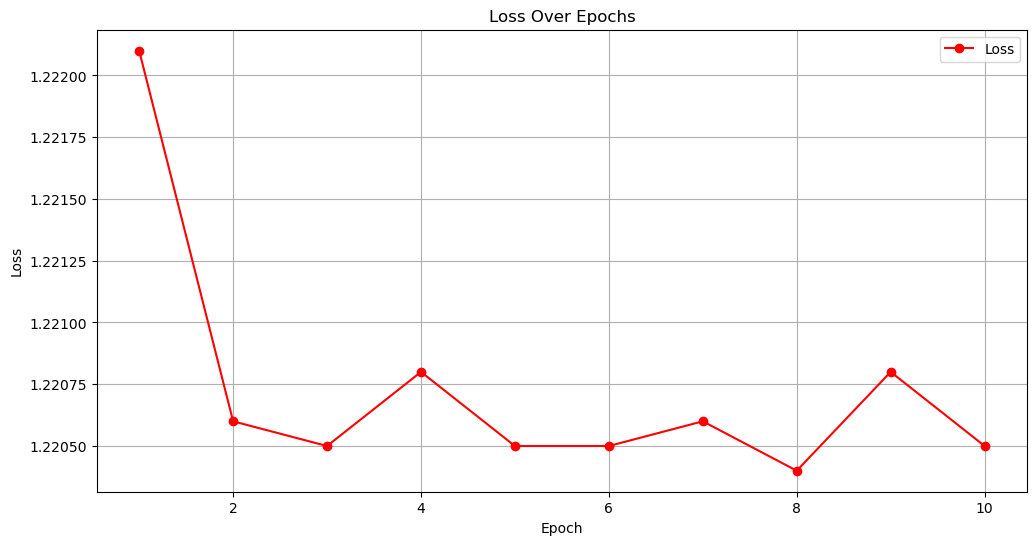

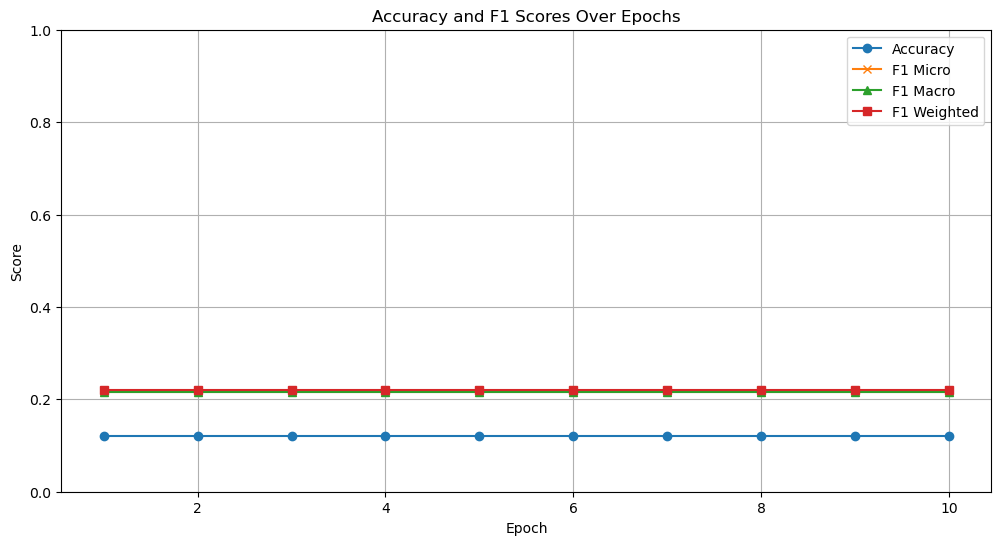

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
loss = [1.2221, 1.2206, 1.2205, 1.2208, 1.2205, 1.2205, 1.2206, 1.2204, 1.2208, 1.2205]
accuracy = [0.1207] * 10
f1_micro = [0.2154] * 10
f1_macro = [0.2148] * 10
f1_weighted = [0.2209] * 10

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, marker='o', color='red', label='Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy, marker='o', label='Accuracy')
plt.plot(epochs, f1_micro, marker='x', label='F1 Micro')
plt.plot(epochs, f1_macro, marker='^', label='F1 Macro')
plt.plot(epochs, f1_weighted, marker='s', label='F1 Weighted')
plt.title('Accuracy and F1 Scores Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
"""
Hyperparameters to tune for the LSTM Model

S/N  ||Hyperparameter   ||Current Value  ||Recommended Value    ||Comments
--------------------------------------------------------------------------
1) Sequence_len || 512 || 128, 256, 512 || Longer Seq helps depending on the synopsis length

2) embed_dim || - || 100,200,300 || 200/300 is fitting for defined and pretrained models

3) hidden_dim || - || 64, 128, 256 || higher dimension models sequence complexity

4) Threshold || - || optimal threshold to be used only after the first epoch

5) dropout || 0 || 0.5 || would help regularization

6) Epochs || 10|| 20|| Longer training to see improvement

7) LSTM Layers  || None || 2|| Need to capture deeper patterns

"""

In [ ]:
# to download, extract and load the glove embeddings 

import os
import zipfile
import urllib.request

glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = "glove.6B.zip"
glove_folder = "glove.6B"
glove_file = "glove.6B.100d.txt"
glove_path = os.path.join(glove_folder, glove_file)

if not os.path.exists(glove_zip_path):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve(glove_url, glove_zip_path)
    print("Download completed.")

if not os.path.exists(glove_folder):
    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(glove_zip_path, "r") as zip_ref:
        zip_ref.extractall(glove_folder)
    print("Extraction completed.")


if not os.path.exists(glove_path):
    raise FileNotFoundError(f"Expected GloVe file not found at {glove_path}. Check extraction folder.")


print("Loading GloVe embeddings into memory...")
embedding_dim = 100
embeddings_index = {}

with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = list(map(float, values[1:]))
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

Loading GloVe embeddings into memory...
Loaded 400000 word vectors from GloVe.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string
from tqdm import tqdm


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)


def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df["overview"] = df["overview"].apply(clean_text)


tokenized = df["overview"].apply(word_tokenize)


from collections import Counter
counter = Counter()
for tokens in tokenized:
    counter.update(tokens)
vocab = {word: i+2 for i, (word, _) in enumerate(counter.items())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

glove_path = os.path.join("glove.6B", "glove.6B.100d.txt")
embedding_dim = 100
embeddings_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

def encode_tokens(tokens, vocab, max_len=200):
    encoded = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(encoded) < max_len:
        encoded += [vocab["<PAD>"]] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded

df["input_ids"] = tokenized.apply(lambda x: encode_tokens(x, vocab))

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df["genres"])


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["input_ids"].tolist(), labels, test_size=0.2, random_state=42)


class MovieDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)

train_dataset = MovieDataset(X_train, y_train)
test_dataset = MovieDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class GenreClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True  # Allow fine-tuning of GloVe embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        out = self.dropout(torch.mean(output, dim=1))
        return self.fc(out)

model = GenreClassifier(vocab_size=len(vocab), embedding_dim=embedding_dim, hidden_dim=256, output_dim=len(mlb.classes_), embedding_matrix=embedding_matrix, dropout=0.5).to(device)


label_counts = labels.sum(axis=0)
pos_weights = (len(labels) - label_counts) / (label_counts + 1e-5) 
pos_weights = torch.tensor(pos_weights, dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train(model, loader):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        all_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return epoch_loss / len(loader), all_preds, all_labels


def evaluate(model, loader):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return epoch_loss / len(loader), all_preds, all_labels

def get_optimal_thresholds(y_true, y_probs):
    thresholds = []
    for i in range(y_true.shape[1]):
        best_thresh = 0.5
        best_f1 = 0
        for thresh in np.linspace(0.1, 0.9, 81):  
            preds = (y_probs[:, i] >= thresh).astype(int)
            f1 = f1_score(y_true[:, i], preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        thresholds.append(best_thresh)
    return np.array(thresholds)


train_losses, val_losses = [], []
accuracy = []
f1_weighted_score = []

train_losses, val_losses = [], []
accuracy = []
f1_weighted_score = []

thresholds = None  

for epoch in range(20):
    train_loss, train_preds, train_true = train(model, train_loader)
    val_loss, val_preds, val_true = evaluate(model, test_loader)

    val_preds_np = np.array(val_preds)
    val_true_np = np.array(val_true)

    if thresholds is None:
        thresholds = get_optimal_thresholds(val_true_np, val_preds_np)

    val_bin = (val_preds_np >= thresholds).astype(int)

    print(f"Epoch {epoch+1}/20 - Loss: {val_loss:.4f}")
    print("Val preds range:", np.min(val_preds_np), np.max(val_preds_np))
    print("Sample preds:", val_bin[0])
    print("Sample labels:", val_true_np[0])

    acc = accuracy_score(val_true_np, val_bin)
    f1_micro = f1_score(val_true_np, val_bin, average='micro', zero_division=0)
    f1_macro = f1_score(val_true_np, val_bin, average='macro', zero_division=0)
    f1_weighted = f1_score(val_true_np, val_bin, average='weighted', zero_division=0)

    print(f"Acc: {acc:.3f} | F1 Micro: {f1_micro:.3f} | F1 Macro: {f1_macro:.3f} | F1 Weighted: {f1_weighted:.3f}")
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracy.append(acc)
    f1_weighted_score.append(f1_weighted)



# ....classification report
val_bin_final = (val_preds_np > thresholds).astype(int)
print(classification_report(y_test, val_bin_final, target_names=mlb.classes_, zero_division=0))


Using device: mps
Epoch 1/20 - Loss: 1.0552
Val preds range: 0.0032767802 0.9968374
Sample preds: [1 1 1 0 0 0 0 0 1 1 0 0 1 0]
Sample labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Acc: 0.042 | F1 Micro: 0.395 | F1 Macro: 0.406 | F1 Weighted: 0.405
Epoch 2/20 - Loss: 0.9149
Val preds range: 9.2457274e-05 0.9999056
Sample preds: [1 1 0 0 0 0 0 0 0 1 1 0 1 1]
Sample labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Acc: 0.051 | F1 Micro: 0.429 | F1 Macro: 0.453 | F1 Weighted: 0.448
Epoch 3/20 - Loss: 0.8740
Val preds range: 2.880441e-05 0.99996734
Sample preds: [1 1 0 0 0 0 0 0 0 1 1 0 1 0]
Sample labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Acc: 0.066 | F1 Micro: 0.457 | F1 Macro: 0.478 | F1 Weighted: 0.475
Epoch 4/20 - Loss: 0.8882
Val preds range: 1.6164284e-06 0.9999783
Sample preds: [0 0 0 0 0 0 0 0 0 1 1 0 1 1]
Sample labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Acc: 0.069 | F1 Micro: 0.472 | F1 Macro: 0.492 | F1 Weighted: 0.488
Epoch 5/20 - Loss: 0.9158
Val p

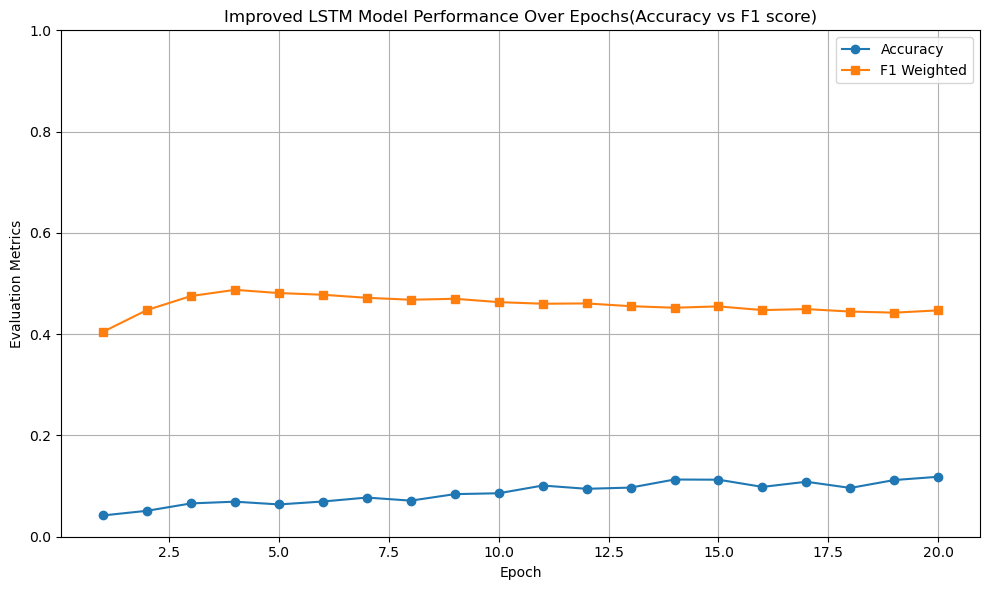

In [23]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(accuracy) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Accuracy', marker='o')
plt.plot(epochs, f1_weighted_score, label='F1 Weighted', marker='s')

plt.title('Improved LSTM Model Performance Over Epochs(Accuracy vs F1 score)')
plt.xlabel('Epoch')
plt.ylabel('Evaluation Metrics')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


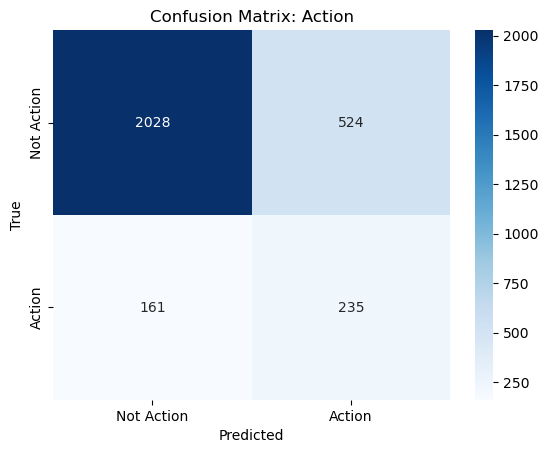

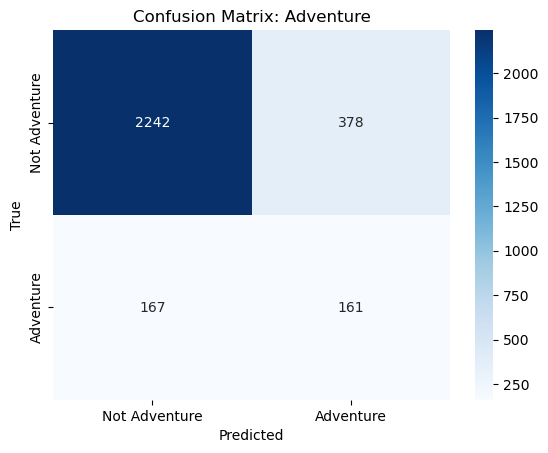

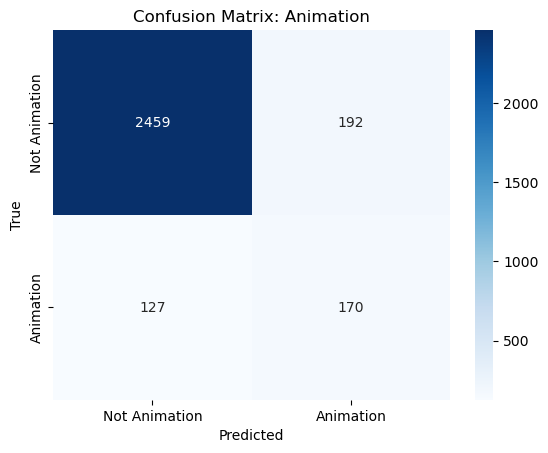

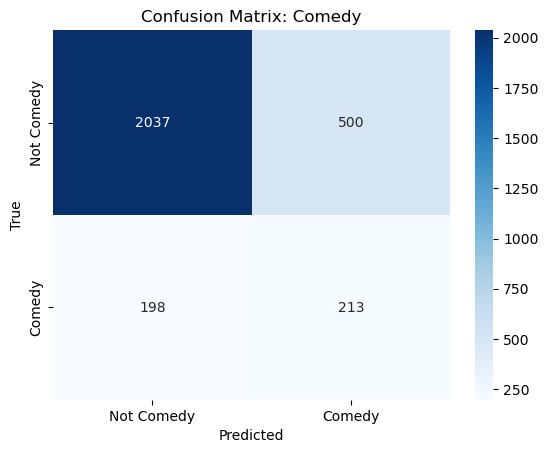

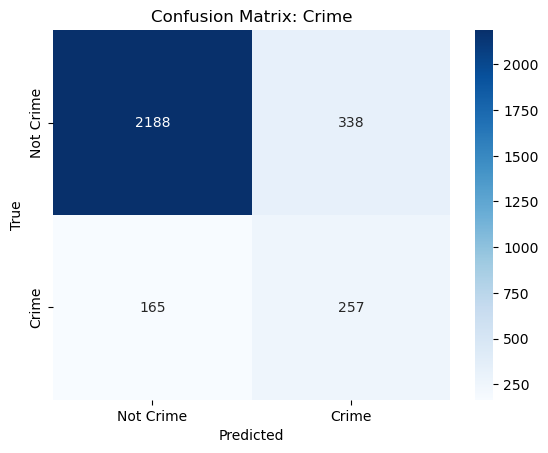

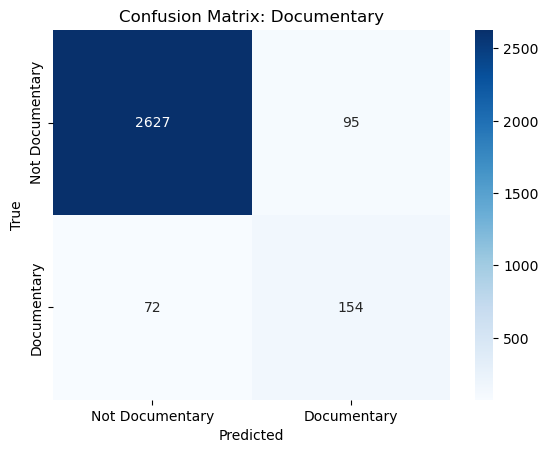

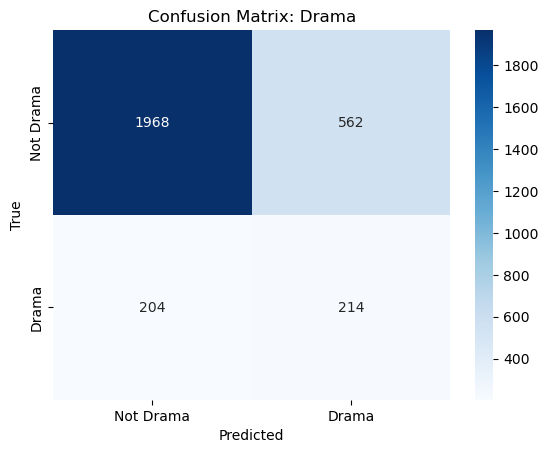

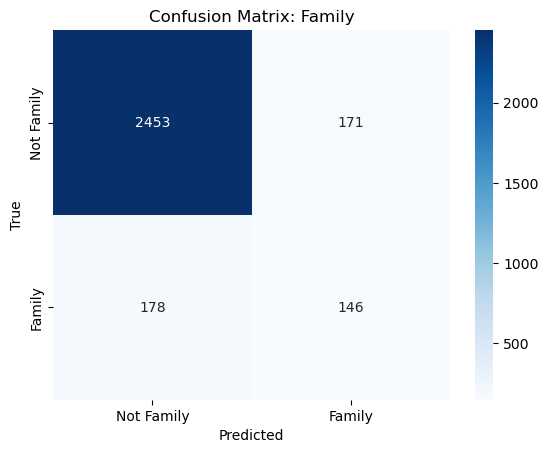

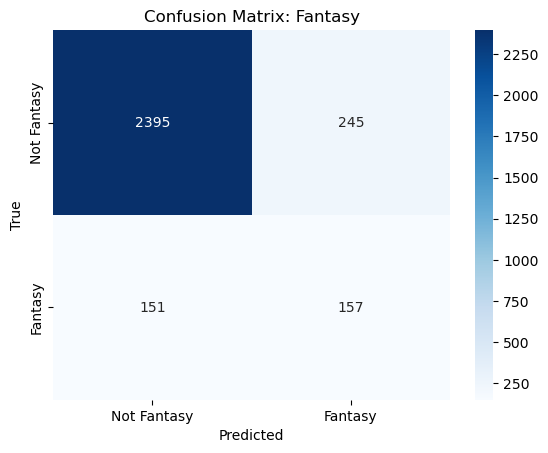

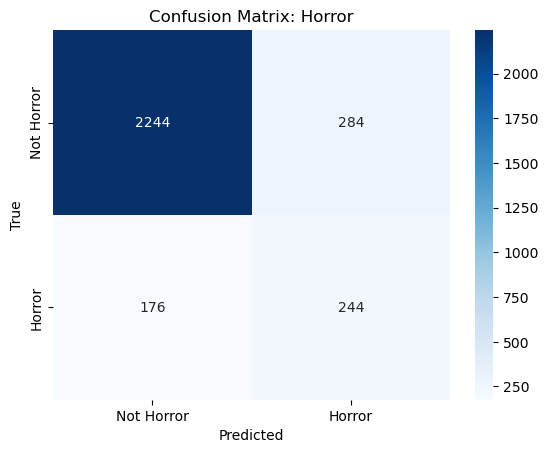

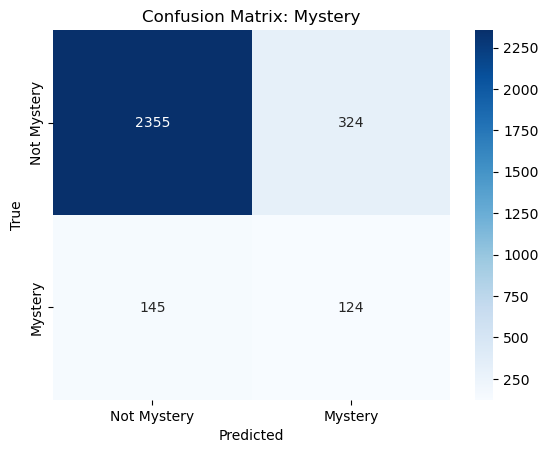

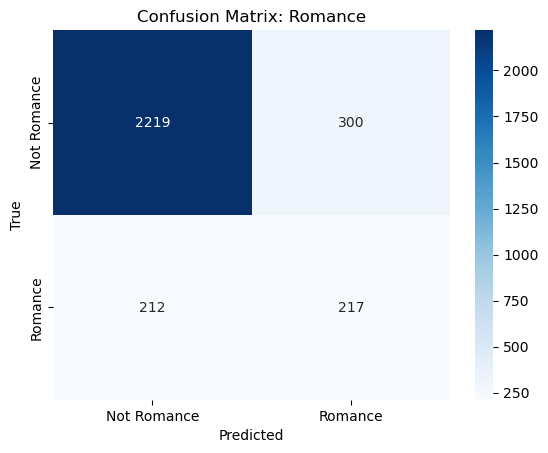

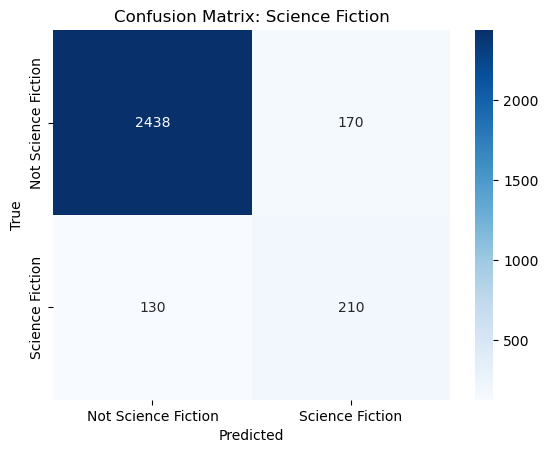

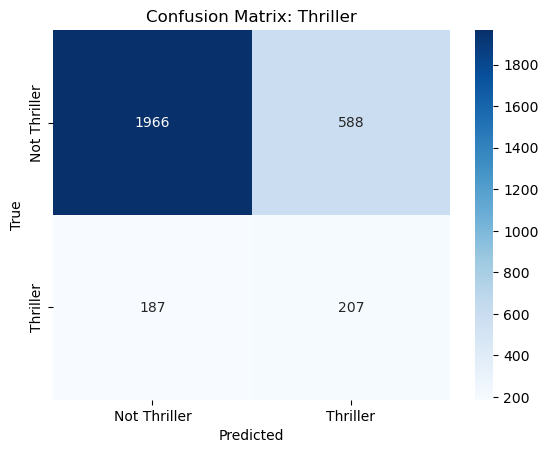

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


val_bin_final = (np.array(val_preds) >= thresholds).astype(int)


conf_matrices = multilabel_confusion_matrix(np.array(y_test), val_bin_final)

for i, genre in enumerate(mlb.classes_):
    cm = conf_matrices[i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not " + genre, genre], yticklabels=["Not " + genre, genre])
    plt.title(f"Confusion Matrix: {genre}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [ ]:
wrong_preds = np.where(~(val_bin_final == np.array(y_test)).all(axis=1))[0]


for i in wrong_preds[:5]:
    true_genres = [mlb.classes_[j] for j in range(len(mlb.classes_)) if y_test[i][j] == 1]
    pred_genres = [mlb.classes_[j] for j in range(len(mlb.classes_)) if val_bin_final[i][j] == 1]
    print(f"True: {true_genres} | Predicted: {pred_genres}")


True: ['Mystery'] | Predicted: ['Adventure', 'Mystery', 'Science Fiction']
True: ['Action', 'Crime'] | Predicted: ['Crime', 'Thriller']
True: ['Thriller'] | Predicted: ['Crime', 'Thriller']
True: ['Horror'] | Predicted: ['Horror', 'Thriller']
True: ['Comedy'] | Predicted: ['Romance']


In [20]:
import os
text_model_dir = "text_model"
os.makedirs(text_model_dir, exist_ok=True)

text_model_path = os.path.join(text_model_dir, "text_model.pt")
torch.save(model.state_dict(), text_model_path)
print(f"Model saved to {text_model_path}")

Model saved to text_model/text_model.pt


In [21]:
import pickle

with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

In [ ]:
np.save("embedding_matrix.npy", embedding_matrix)